In [103]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras_preprocessing.text import text_to_word_sequence
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer

In [83]:
class DimensionTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

загрузили данные 

In [84]:
data_train = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None)
data_train.columns = ['Texts', 'Labels']
data_test = pd.read_csv('products_sentiment_test.tsv', sep='\t', header=None)
data_test.columns = ['Id', 'Texts']

Переделали коллекию текстов в коллекцию слов. Число признаков стало 3973.

In [85]:
Texts = np.array(data_train['Texts'])
Words = [' '.join(text) for text in [text_to_word_sequence(text, filters='"#%&*,/;<=>?@[\\]^_`{|}~\t\n') for text in Texts]]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(np.array(Words))

In [86]:
X

<2000x3973 sparse matrix of type '<class 'numpy.int64'>'
	with 29639 stored elements in Compressed Sparse Row format>

Использовали логистическую регресию в качестве старта. Вывели на экран слова, которые являются наиболее значимыми при кластеризации. 

In [87]:
Features = vectorizer.get_feature_names()
log_reg = LogisticRegression()
log_reg.fit(X, data_train['Labels'])

abs_weights = np.abs(log_reg.coef_)
Imp_indexes = abs_weights[0].argsort()[-5:]
print('The most important features = ', np.array(Features)[Imp_indexes])

The most important features =  ['only' 'easy' 'excellent' 'love' 'great']


Ищем наиболее оптимальный дескриптор

In [88]:
pip_cv_lr= Pipeline([('count_vec', CountVectorizer()), 
                      ('reg', LogisticRegression())])
accuracy_mean = cross_val_score(pip_cv_lr, Words, data_train['Labels'], scoring='accuracy', cv=5).mean()
roc_auc_mean = cross_val_score(pip_cv_lr, Words, data_train['Labels'], scoring='roc_auc', cv=5).mean()
print('accuracy (CountVectorizer + LogisticRegression) = ', accuracy_mean)
print('roc_auc (CountVectorizer + LogisticRegression) = ', roc_auc_mean)

accuracy (CountVectorizer + LogisticRegression) =  0.7684956843480272
roc_auc (CountVectorizer + LogisticRegression) =  0.8369861339229565


In [89]:
pip_tv_lr= Pipeline([('count_vec', TfidfVectorizer()), 
                      ('reg', LogisticRegression())])
accuracy_mean = cross_val_score(pip_tv_lr, Words, data_train['Labels'], scoring='accuracy', cv=5).mean()
roc_auc_mean = cross_val_score(pip_tv_lr, Words, data_train['Labels'], scoring='roc_auc', cv=5).mean()
print('accuracy (TfidfVectorizer + LogisticRegression) = ', accuracy_mean)
print('roc_auc (TfidfVectorizer + LogisticRegression) = ', roc_auc_mean)

accuracy (TfidfVectorizer + LogisticRegression) =  0.7665031843949025
roc_auc (TfidfVectorizer + LogisticRegression) =  0.8512215609187672


TfidfVectorizer() работает лучше, чем CountVectorizer()

In [56]:
tf_vectorizer = TfidfVectorizer()
X_tf = tf_vectorizer.fit_transform(np.array(Words))

In [66]:
transf = PCA(n_components=0.95, svd_solver='full')
X_pca = transf.fit_transform(X_tf.toarray())

In [67]:
pip_tv_pca_lr= Pipeline([('reg', LogisticRegression())])

accuracy_mean = cross_val_score(pip_tv_pca_lr, X_pca, data_train['Labels'], scoring='accuracy', cv=5).mean()
roc_auc_mean = cross_val_score(pip_tv_pca_lr, X_pca, data_train['Labels'], scoring='roc_auc', cv=5).mean()
print('accuracy (TfidfVectorizer + LogisticRegression) = ', accuracy_mean)
print('roc_auc (TfidfVectorizer + LogisticRegression) = ', roc_auc_mean)

accuracy (TfidfVectorizer + LogisticRegression) =  0.7670081781761137
roc_auc (TfidfVectorizer + LogisticRegression) =  0.8517361541427538


делим данные на тренировочную и тестовую выборки с стратефикацией

In [90]:
train_data, val_data, train_y, val_y = train_test_split(Words, data_train['Labels'], test_size = 0.2, random_state = 1, stratify = np.array(data_train['Labels']))

In [ ]:
pip_tv_lr_params= Pipeline([('countvec', TfidfVectorizer()), 
                      ('reg', LogisticRegression())])

param_grid = {'countvec__stop_words': [None],
              'countvec__analyzer': ['word'],
                         'countvec__ngram_range': [(1,2)],
                         #'countvec__min_df': [0.05], 
                         #'countvec__max_df': [0.95],
             'reg__penalty': ['l2'], 
             'reg__C': [5], 
             'reg__random_state': [0]}

grid_log = GridSearchCV(pip_tv_lr_params, param_grid, cv=5, scoring='accuracy')
grid_log.fit(train_data, train_y)

print('Best score = ', grid_log.best_score_)
print('Best estimator = ', grid_log.best_estimator_)
print('accuracy train = ', accuracy_score(train_y, grid_log.best_estimator_.predict(train_data)))
print('accuracy test = ',accuracy_score(val_y, grid_log.best_estimator_.predict(val_data)))

In [71]:
pip_tv_svc_params = Pipeline([('countvec', TfidfVectorizer()),
                      ('svc', SVC())])

param_grid = {'countvec__stop_words': ['english', None],
              'countvec__analyzer': [ 'word'],
                         'countvec__ngram_range': [(1,2)],
                         #'countvec__min_df': [0.05], 
                         #'countvec__max_df': [0.95],
              'svc__kernel': ['linear', 'rbf', 'sigmoid'],
              'svc__gamma': np.logspace(-7, 0 ,5),
             'svc__C': [1], 
             'svc__random_state': [0]}


grid = GridSearchCV(pip_tv_svc_params, param_grid, cv=5, scoring='accuracy')
grid.fit(train_data, train_y)

print('Best score = ', grid.best_score_)
print('Best estimator = ', grid.best_estimator_)
print('accuracy train = ', accuracy_score(train_y, grid.best_estimator_.predict(train_data)))
print('accuracy test = ',accuracy_score(val_y, grid.best_estimator_.predict(val_data)))


Best score =  0.786875
Best estimator =  Pipeline(memory=None,
         steps=[('countvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_f

In [74]:
train_data_pca, val_data_pca, train_y_pca, val_y_pca = train_test_split(X_pca, data_train['Labels'], test_size = 0.2, random_state = 1, stratify = np.array(data_train['Labels']))

In [ ]:
est = grid.best_estimator_

сделаем прогноз и запишем в файл решение для загрузки на Kaggle

In [ ]:
Texts_test = np.array(data_test['Texts'])
Words_test = [' '.join(text) for text in [text_to_word_sequence(text1, filters='"#%&*,/;<=>?@[\\]^_`{|}~\t\n') for text1 in Texts_test]]

In [ ]:
preds = est.predict(Words_test)
ans = pd.DataFrame({'Id' : np.arange(0, len(preds)), 'y' : np.array(preds)})
ans.to_csv('submission.csv', index=False)

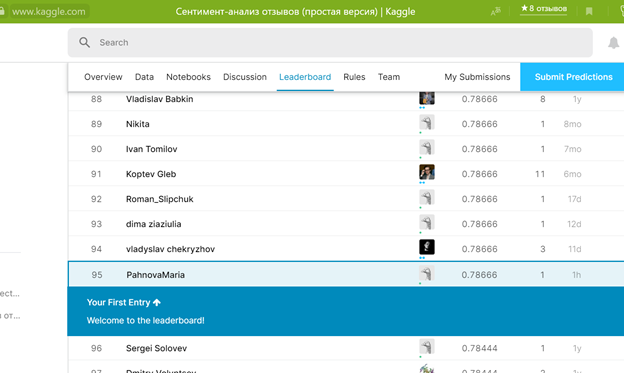

In [108]:
import pickle 

with open('model.pkl', 'wb') as f:
    pickle.dump(est, f)